# ME-IIS Colab Benchmark (12 Office-Home transfers)

Colab-first pipeline that caches datasets/checkpoints in Google Drive while training on local SSD.
Pulls the latest `main`, sets up dependencies once, and runs the baseline UDA suite: `source_only`, `dann`, `dan`, `jan`, `cdan`, `me_iis`.
Handles dataset bootstrap via KaggleHub, deterministic naming, and skips work when artifacts already exist.
Executes all 12 Office-Home transfer pairs with seeds/config defined in one place.
Uses GPU + AMP when available, auto-tunes dataloaders, and avoids Drive I/O during training.
Aggregates metrics, plots, and writes summary CSVs + checkpoints back to Drive.
        


In [1]:
import os
import sys
import shutil
from pathlib import Path

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    from google.colab import drive  # type: ignore
    drive.mount("/content/drive", force_remount=False)
else:
    print("Not running inside Colab; skipping Drive mount (paths still target /content).")

DRIVE_ROOT = Path("/content/drive/MyDrive/ME-IIS")
DATASETS_DRIVE = DRIVE_ROOT / "datasets"
RUNS_DRIVE = DRIVE_ROOT / "runs"
WORKDIR = Path("/content/work")

for path in [DRIVE_ROOT, DATASETS_DRIVE, RUNS_DRIVE, WORKDIR]:
    path.mkdir(parents=True, exist_ok=True)


def _format_bytes(num):
    try:
        if num is None:
            return "unknown"
        num = float(num)
        for unit in ["B", "KB", "MB", "GB", "TB", "PB"]:
            if num < 1024 or unit == "PB":
                return f"{num:.2f}{unit}"
            num /= 1024.0
    except Exception:
        return str(num)


def _print_disk(path, label):
    try:
        total, used, free = shutil.disk_usage(str(path))
        print(f"{label}: total={_format_bytes(total)} free={_format_bytes(free)} path={path}")
    except Exception as exc:
        print(f"{label}: unable to read disk usage ({exc})")


_print_disk("/content", "Local /content disk")
if DRIVE_ROOT.exists():
    _print_disk(DRIVE_ROOT, "Drive disk")
else:
    print("Drive path missing (mount may have been skipped).")


def print_system_info():
    gpu_msg = "GPU: none detected"
    try:
        import torch

        if torch.cuda.is_available():
            props = torch.cuda.get_device_properties(0)
            free, total = torch.cuda.mem_get_info()
            gpu_msg = f"GPU: {props.name} free={_format_bytes(free)} total={_format_bytes(total)}"
        else:
            gpu_msg = "GPU: CPU-only runtime"
    except Exception as exc:
        gpu_msg = f"GPU check failed: {exc}"
    print(gpu_msg)

    cpu = os.cpu_count()
    print(f"CPU cores: {cpu}")
    try:
        import psutil  # type: ignore

        vm = psutil.virtual_memory()
        print(f"RAM: total={_format_bytes(vm.total)} available={_format_bytes(vm.available)}")
    except Exception:
        print("RAM: psutil not available")
    _print_disk("/content", "Local disk snapshot")


print_system_info()
print(f"DRIVE_ROOT={DRIVE_ROOT}")
print("Avoid saving checkpoints directly to Drive during training; final artifacts are copied after runs.")



Mounted at /content/drive
Local /content disk: total=235.68GB free=197.21GB path=/content
Drive disk: total=15.00GB free=5.92GB path=/content/drive/MyDrive/ME-IIS
GPU: NVIDIA A100-SXM4-40GB free=39.14GB total=39.56GB
CPU cores: 12
RAM: total=83.47GB available=81.01GB
Local disk snapshot: total=235.68GB free=197.21GB path=/content
DRIVE_ROOT=/content/drive/MyDrive/ME-IIS
Avoid saving checkpoints directly to Drive during training; final artifacts are copied after runs.


In [2]:
import subprocess
from pathlib import Path

REPO_URL = "https://github.com/kaminglui/ME-IIS.git"
REPO_DIR = Path("/content/ME-IIS")

if not REPO_DIR.exists():
    print("Cloning repo...")
    subprocess.check_call(["git", "clone", "--depth", "1", REPO_URL, str(REPO_DIR)])
else:
    print("Repo already present, fetching latest main...")
    subprocess.check_call(["git", "-C", str(REPO_DIR), "fetch", "--all", "--tags"])
    subprocess.check_call(["git", "-C", str(REPO_DIR), "checkout", "main"])
    subprocess.check_call(["git", "-C", str(REPO_DIR), "pull", "--ff-only"])

sha = (
    subprocess.check_output(["git", "-C", str(REPO_DIR), "rev-parse", "HEAD"], text=True)
    .strip()
)
status = subprocess.check_output(["git", "-C", str(REPO_DIR), "status", "-sb"], text=True).strip()

print(f"HEAD commit: {sha}")
print("Git status:")
print(status)

import sys

if str(REPO_DIR) not in sys.path:
    sys.path.insert(0, str(REPO_DIR))



Cloning repo...
HEAD commit: b63ed8c326a6dee411cb4284965cc085b3b8ecf5
Git status:
## main...origin/main


In [3]:
import importlib
import subprocess
import sys
from pathlib import Path

REQ_FILE = Path(REPO_DIR) / "requirements.txt"


def _is_installed(mod_name: str) -> bool:
    try:
        importlib.import_module(mod_name)
        return True
    except ImportError:
        return False


missing_core = [m for m in ["torch", "torchvision", "sklearn"] if not _is_installed(m)]
if missing_core:
    print(f"Installing requirements (missing: {missing_core})...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "-r", str(REQ_FILE)])
else:
    print("Core packages already installed; skipping requirements install.")

if not _is_installed("kagglehub"):
    print("Installing kagglehub for dataset downloads...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "kagglehub"])
else:
    print("kagglehub already installed.")



Core packages already installed; skipping requirements install.
kagglehub already installed.


In [5]:
import os
import json
import shutil
import zipfile
from pathlib import Path
from typing import Any, Dict

import kagglehub

OFFICE_HOME_DOMAIN_SETS = [
    ["Art", "Clipart", "Product", "RealWorld"],
    ["Art", "Clipart", "Product", "Real World"],
    ["Art", "Clipart", "Product", "Real_World"],
    ["Art", "Clipart", "Product", "Real"],
]
OFFICE31_DOMAINS = ["amazon", "dslr", "webcam"]


def _maybe_extract_zip(path: Path) -> Path:
    if path.is_file() and path.suffix.lower() == ".zip":
        target = path.with_suffix("")
        target.mkdir(parents=True, exist_ok=True)
        marker = target / ".extracted_ok"
        if not marker.exists():
            print(f"[DATA] Extracting {path} -> {target}")
            with zipfile.ZipFile(path, "r") as zf:
                zf.extractall(target)
            marker.write_text("ok", encoding="utf-8")
        return target
    return path


def _find_office_home_root(raw: Path) -> Path:
    raw = _maybe_extract_zip(Path(raw))
    candidates = [raw] + [p for p in raw.rglob("*") if p.is_dir()]
    for candidate in candidates:
        for domains in OFFICE_HOME_DOMAIN_SETS:
            if all((candidate / d).exists() for d in domains):
                return candidate
    raise FileNotFoundError(f"Could not locate Office-Home domains under {raw}")


def _find_office31_root(raw: Path) -> Path:
    raw = _maybe_extract_zip(Path(raw))
    candidates = [raw] + [p for p in raw.rglob("*") if p.is_dir()]
    for candidate in candidates:
        if all((candidate / d).exists() for d in OFFICE31_DOMAINS):
            return candidate
    raise FileNotFoundError(f"Could not locate Office-31 domains under {raw}")


def resolve_dataset_root(dataset_name: str) -> Path:
    if dataset_name == "office_home":
        raw = Path(kagglehub.dataset_download("lhrrraname/officehome"))
        return _find_office_home_root(raw)
    if dataset_name == "office31":
        raw = Path(kagglehub.dataset_download("xixuhu/office31"))
        return _find_office31_root(raw)
    raise ValueError(f"Unknown DATASET_NAME={dataset_name}")


def _dir_size_bytes(path: Path) -> int:
    total = 0
    for fp in path.rglob("*"):
        if fp.is_file():
            try:
                total += int(fp.stat().st_size)
            except Exception:
                continue
    return total


def ensure_dataset_in_drive(dataset_name: str, datasets_drive_dir: Path) -> Path:
    datasets_drive_dir = Path(datasets_drive_dir)
    datasets_drive_dir.mkdir(parents=True, exist_ok=True)
    drive_path = datasets_drive_dir / dataset_name
    if drive_path.exists():
        print(f"[DATA] Using cached dataset in Drive: {drive_path}")
        return drive_path
    raw_root = resolve_dataset_root(dataset_name)
    drive_path.mkdir(parents=True, exist_ok=True)
    print(f"[DATA] Copying dataset into Drive cache: {raw_root} -> {drive_path}")
    shutil.copytree(raw_root, drive_path, dirs_exist_ok=True)
    return drive_path


def maybe_copy_dataset_to_local(drive_path: Path, local_path: Path, enable: bool = True, headroom_gb: int = 5) -> Path:
    drive_path = Path(drive_path)
    local_path = Path(local_path)
    if not enable:
        print(f"[DATA] Local caching disabled; using Drive path: {drive_path}")
        return drive_path
    marker = local_path / ".cached_ok"
    if marker.exists():
        print(f"[DATA] Using existing local copy: {local_path}")
        return local_path
    try:
        free = shutil.disk_usage(str(local_path.parent)).free
    except Exception:
        free = None
    dataset_size = _dir_size_bytes(drive_path)
    if free is not None and dataset_size > max(0, free - headroom_gb * 1024**3):
        print(f"[DATA] Insufficient local disk; using Drive path ({drive_path})")
        return drive_path
    local_path.parent.mkdir(parents=True, exist_ok=True)
    print(f"[DATA] Copying dataset from Drive to local SSD: {drive_path} -> {local_path}")
    shutil.copytree(drive_path, local_path, dirs_exist_ok=True)
    marker.write_text("ok", encoding="utf-8")
    return local_path


print("Dataset helpers ready. Use ensure_dataset_in_drive(...) then maybe_copy_dataset_to_local(...).")



Dataset helpers ready. Use ensure_dataset_in_drive(...) then maybe_copy_dataset_to_local(...).


In [6]:
import os
from datetime import datetime

DATASETS_LOCAL = WORKDIR / "datasets"
RUNS_LOCAL = WORKDIR / "runs"
RUNS_LOCAL_INTERNAL = WORKDIR / "runs_internal"
for path in [DATASETS_LOCAL, RUNS_LOCAL, RUNS_LOCAL_INTERNAL]:
    path.mkdir(parents=True, exist_ok=True)

DATASET_NAME = "office_home"
DOMAINS = ["Ar", "Cl", "Pr", "Rw"] if DATASET_NAME == "office_home" else ["A", "D", "W"]
METHODS = ["source_only", "dann", "dan", "jan", "cdan", "me_iis"]  # CORAL intentionally excluded
SEEDS = [0]  # for full benchmark: [0, 1, 2]

EPOCHS_SOURCE = 50
EPOCHS_ADAPT = 10
BATCH_SIZE = 32  # set to "auto" to probe largest fitting batch
NUM_WORKERS = "auto"  # auto-tuned below
AMP = True
DETERMINISTIC = False
FORCE_RERUN = False
SAVE_EVERY_EPOCH = False

BACKBONE = "resnet50"
INPUT_SIZE = 224

timestamp = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
RUN_TAG = f"{DATASET_NAME}_full_{timestamp}"

SOURCE_ONLY_PARAMS = {"amp": AMP}

DANN_PARAMS = {
    "amp": AMP,
    "disc_hidden_dim": 1024,
    "disc_dropout": 0.1,
    "grl_lambda_schedule": "grl",
    "domain_loss_weight": 1.0,
}

DAN_PARAMS = {
    "amp": AMP,
    "mmd_loss_weight": 1.0,
    "mmd_kernel_mul": 2.0,
    "mmd_kernel_num": 5,
    "mmd_fix_sigma": None,
}

JAN_PARAMS = {
    "amp": AMP,
    "jmmd_loss_weight": 1.0,
    "jmmd_kernel_mul": 2.0,
    "jmmd_kernel_num": 5,
    "jmmd_fix_sigma": None,
}

CDAN_PARAMS = {
    "amp": AMP,
    "disc_hidden_dim": 1024,
    "disc_dropout": 0.1,
    "domain_loss_weight": 1.0,
    "grl_lambda_schedule": "grl",
    "entropy_conditioning": False,
}

ME_IIS_PARAMS = {
    "amp": AMP,
    "feature_layers": ["layer3", "layer4"],
    "num_latent_styles": 5,
    "gmm_bic_min_components": 2,
    "gmm_bic_max_components": 8,
    "gmm_reg_covar": 1e-6,
    "gmm_selection_mode": "bic",
    "iis_iters": 15,
    "iis_tol": 1e-3,
    "cluster_backend": "gmm",
    "cluster_clean_ratio": 1.0,
    "kmeans_n_init": 10,
    "source_prob_mode": "softmax",
    "use_pseudo_labels": False,
    "pseudo_conf_thresh": 0.9,
    "pseudo_max_ratio": 1.0,
    "pseudo_loss_weight": 1.0,
    "weight_clip_max": None,
    "weight_mix_alpha": 0.0,
}

METHOD_PARAMS = {
    "source_only": SOURCE_ONLY_PARAMS,
    "dann": DANN_PARAMS,
    "dan": DAN_PARAMS,
    "jan": JAN_PARAMS,
    "cdan": CDAN_PARAMS,
    "me_iis": ME_IIS_PARAMS,
}

os.environ.setdefault("ME_IIS_AUTO_RESOURCES", "1")
print(f"Config ready | RUN_TAG={RUN_TAG} | METHODS={METHODS} | DOMAINS={DOMAINS}")



Config ready | RUN_TAG=office_home_full_20251216_050010 | METHODS=['source_only', 'dann', 'dan', 'jan', 'cdan', 'me_iis'] | DOMAINS=['Ar', 'Cl', 'Pr', 'Rw']


/tmp/ipython-input-4137037307.py:27: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().strftime("%Y%m%d_%H%M%S")


In [7]:
import re
from pathlib import Path
from typing import Any, Dict


def _layer_tag(params: Dict[str, Any]) -> str:
    layers = params.get("feature_layers", ["layer3", "layer4"])
    if isinstance(layers, str):
        layers = [p.strip() for p in layers.split(",") if p.strip()]
    return "-".join(layers)


def make_run_dir(method: str, dataset: str, src: str, tgt: str, seed: int, base: Path | None = None) -> Path:
    base = Path(base or RUNS_LOCAL)
    return base / str(RUN_TAG) / str(dataset) / f"{src}2{tgt}" / str(method) / f"seed{seed}"


def make_ckpt_name(
    method: str,
    dataset: str,
    src: str,
    tgt: str,
    seed: int,
    *,
    batch_size: Any | None = None,
    epochs_source: Any | None = None,
    epochs_adapt: Any | None = None,
    method_params: Dict[str, Any] | None = None,
) -> str:
    bs_tag = batch_size if batch_size is not None else BATCH_SIZE
    es_tag = epochs_source if epochs_source is not None else EPOCHS_SOURCE
    ea_tag = epochs_adapt if epochs_adapt is not None else EPOCHS_ADAPT
    name = f"{method}__{dataset}__{src}2{tgt}__seed{seed}__Esrc{es_tag}__Ead{ea_tag}__bs{bs_tag}"
    if method == "me_iis":
        params = method_params or METHOD_PARAMS.get("me_iis", {})
        layer_tag = _layer_tag(params)
        gmm_min = params.get("gmm_bic_min_components", 2)
        gmm_max = params.get("gmm_bic_max_components", 8)
        iis_iters = params.get("iis_iters", 15)
        iis_tol = params.get("iis_tol", 1e-3)
        name += f"__layers{layer_tag}__gmm{gmm_min}-{gmm_max}__iis{iis_iters}-{iis_tol}"
    return name + ".pt"


def decode_ckpt_name(name: str) -> Dict[str, Any]:
    stem = Path(name).name.replace(".pt", "")
    parts = stem.split("__")
    info: Dict[str, Any] = {"raw": stem}
    try:
        method, dataset, pair, seed_part, esrc_part, ead_part, bs_part, *rest = parts
        src, tgt = pair.split("2", 1)
        info.update(
            {
                "method": method,
                "dataset": dataset,
                "src": src,
                "tgt": tgt,
                "seed": int(seed_part.replace("seed", "")),
                "epochs_source": esrc_part.replace("Esrc", ""),
                "epochs_adapt": ead_part.replace("Ead", ""),
                "batch_size": bs_part.replace("bs", ""),
            }
        )
        for token in rest:
            if token.startswith("layers"):
                info["layers"] = token.replace("layers", "")
            elif token.startswith("gmm"):
                rng = token.replace("gmm", "")
                if "-" in rng:
                    lo, hi = rng.split("-", 1)
                    info["gmm_range"] = (int(lo), int(hi))
            elif token.startswith("iis"):
                payload = token.replace("iis", "")
                if "-" in payload:
                    iters, tol = payload.split("-", 1)
                    info["iis_iters"] = int(float(iters))
                    info["iis_tol"] = float(tol)
    except Exception:
        info["error"] = "unable to decode"
    return info



In [8]:
import math
import random
import os
from typing import Dict, Any

import torch
import numpy as np


def set_global_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = bool(DETERMINISTIC)
    torch.backends.cudnn.benchmark = not bool(DETERMINISTIC)


def auto_dataloader_params(requested: Any = NUM_WORKERS) -> Dict[str, Any]:
    cpu = os.cpu_count() or 2
    num_workers = requested
    if requested == "auto":
        num_workers = min(8, max(2, cpu - 1))
        try:
            import psutil  # type: ignore

            available = psutil.virtual_memory().available
            if available < 8 * 1024**3:
                num_workers = max(0, min(num_workers, 2))
        except Exception:
            pass
    try:
        num_workers = int(num_workers)
    except Exception:
        num_workers = 0
    if num_workers < 0:
        num_workers = 0
    pin_memory = torch.cuda.is_available()
    prefetch = 2 if num_workers > 0 else None
    persistent_workers = bool(num_workers > 0)
    return {
        "num_workers": num_workers,
        "pin_memory": pin_memory,
        "prefetch_factor": prefetch,
        "persistent_workers": persistent_workers,
    }


def auto_batch_size(candidates=(64, 32, 16), device: str | None = None) -> int:
    if BATCH_SIZE != "auto":
        return int(BATCH_SIZE)
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    for bs in candidates:
        try:
            _ = torch.zeros((bs, 3, INPUT_SIZE, INPUT_SIZE), device=device)
            del _
            return int(bs)
        except RuntimeError as exc:
            if "out of memory" in str(exc).lower():
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                continue
            raise
    return int(candidates[-1])


AUTO_DL = auto_dataloader_params(NUM_WORKERS)
AUTO_BATCH = auto_batch_size()
print(f"Auto dataloader params: {AUTO_DL}")
print(f"Batch size (requested={BATCH_SIZE}) resolved to: {AUTO_BATCH}")



Auto dataloader params: {'num_workers': 8, 'pin_memory': True, 'prefetch_factor': 2, 'persistent_workers': True}
Batch size (requested=32) resolved to: 32


In [11]:
import csv
import json
import shutil
import traceback
from pathlib import Path
from typing import Dict, Any

from src.experiments.run_config import RunConfig, get_run_dir
from src.experiments.runner import run_one


def _read_metrics_csv(path: Path) -> tuple[float | None, float | None, Dict[str, Any] | None]:
    if not path.exists():
        return None, None, None
    try:
        with path.open("r", newline="", encoding="utf-8") as f:
            reader = csv.DictReader(f)
            rows = list(reader)
    except Exception:
        return None, None, None
    if not rows:
        return None, None, None
    row = rows[-1]
    try:
        src_acc = float(row.get("source_acc", "nan"))
    except Exception:
        src_acc = None
    try:
        tgt_acc = float(row.get("target_acc", "nan"))
    except Exception:
        tgt_acc = None
    return src_acc, tgt_acc, row


def _safe_copy(src: Path, dst: Path) -> None:
    if src.exists():
        dst.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy2(src, dst)


def run_experiment(
    method: str,
    src: str,
    tgt: str,
    seed: int,
    data_root: Path,
    runs_dir_local: Path,
    runs_dir_drive: Path,
) -> Dict[str, Any]:
    method_params = dict(METHOD_PARAMS.get(method, {}))
    method_params.setdefault("amp", AMP)
    resolved_batch_size = auto_batch_size()
    dl_params = auto_dataloader_params(NUM_WORKERS)
    resolved_num_workers = dl_params["num_workers"]

    run_dir_local = make_run_dir(method, DATASET_NAME, src, tgt, seed, base=runs_dir_local)
    run_dir_drive = make_run_dir(method, DATASET_NAME, src, tgt, seed, base=runs_dir_drive)
    run_dir_local.mkdir(parents=True, exist_ok=True)
    run_dir_drive.mkdir(parents=True, exist_ok=True)

    ckpt_name = make_ckpt_name(
        method,
        DATASET_NAME,
        src,
        tgt,
        seed,
        batch_size=resolved_batch_size,
        method_params=method_params,
    )
    metrics_drive_path = run_dir_drive / "metrics.csv"
    ckpt_drive_path = run_dir_drive / ckpt_name

    config_payload = {
        "run_tag": RUN_TAG,
        "dataset": DATASET_NAME,
        "src": src,
        "tgt": tgt,
        "seed": seed,
        "method": method,
        "epochs_source": EPOCHS_SOURCE,
        "epochs_adapt": EPOCHS_ADAPT,
        "batch_size": resolved_batch_size,
        "num_workers": resolved_num_workers,
        "method_params": method_params,
        "amp": AMP,
        "deterministic": DETERMINISTIC,
        "data_root": str(data_root),
        "run_dir_local": str(run_dir_local),
        "run_dir_drive": str(run_dir_drive),
    }
    for dest in [run_dir_local, run_dir_drive]:
        (Path(dest) / "config.json").write_text(json.dumps(config_payload, indent=2), encoding="utf-8")

    if metrics_drive_path.exists() and ckpt_drive_path.exists() and not FORCE_RERUN:
        src_acc, tgt_acc, row = _read_metrics_csv(metrics_drive_path)
        print(f"[SKIP] found existing artifacts for {method} {src}->{tgt} seed={seed}")
        return {
            "status": "skipped",
            "method": method,
            "src": src,
            "tgt": tgt,
            "seed": seed,
            "source_acc": src_acc,
            "target_acc": tgt_acc,
            "metrics_csv": str(metrics_drive_path),
            "checkpoint": str(ckpt_drive_path),
            "run_dir": str(run_dir_drive),
            "config": config_payload,
        }

    print(f"[RUN] method={method} src={src} tgt={tgt} seed={seed}")
    cfg = RunConfig(
        dataset_name=DATASET_NAME,
        data_root=str(data_root),
        source_domain=src,
        target_domain=tgt,
        method=method,
        backbone=BACKBONE,
        input_size=INPUT_SIZE,
        epochs_source=EPOCHS_SOURCE,
        epochs_adapt=EPOCHS_ADAPT,
        batch_size=int(resolved_batch_size),
        num_workers=int(resolved_num_workers),
        method_params=method_params,
        seed=int(seed),
        deterministic=bool(DETERMINISTIC),
    )

    try:
        result = run_one(
            cfg,
            force_rerun=FORCE_RERUN,
            runs_root=RUNS_LOCAL_INTERNAL,
            write_metrics=True,
            raise_on_error=False,
        )
    except Exception as exc:
        err = traceback.format_exc()
        err_path = run_dir_drive / "stderr.txt"
        err_path.write_text(err, encoding="utf-8")
        return {
            "status": "failed",
            "method": method,
            "src": src,
            "tgt": tgt,
            "seed": seed,
            "error": str(exc),
            "stderr": str(err_path),
            "run_dir": str(run_dir_drive),
        }

    internal_run_dir = get_run_dir(cfg, runs_root=RUNS_LOCAL_INTERNAL)
    metrics_internal = internal_run_dir / "metrics.csv"
    logs_internal = internal_run_dir / "logs"
    ckpt_internal = None
    if isinstance(result, dict) and "checkpoint" in result:
        ckpt_internal = Path(result.get("checkpoint")) if result.get("checkpoint") else None
    if ckpt_internal is None or not ckpt_internal.exists():
        for cand in (internal_run_dir / "checkpoints").glob("*final*.pth"):
            ckpt_internal = cand
            break

    _safe_copy(metrics_internal, run_dir_local / "metrics.csv")
    _safe_copy(metrics_internal, metrics_drive_path)
    if logs_internal.exists():
        shutil.copytree(logs_internal, run_dir_local / "logs", dirs_exist_ok=True)
        shutil.copytree(logs_internal, run_dir_drive / "logs", dirs_exist_ok=True)
    if ckpt_internal is not None and ckpt_internal.exists():
        _safe_copy(ckpt_internal, run_dir_local / ckpt_name)
        _safe_copy(ckpt_internal, ckpt_drive_path)

    src_acc, tgt_acc, row = _read_metrics_csv(run_dir_local / "metrics.csv")
    status = result.get("status", "done") if isinstance(result, dict) else "done"
    print(f"[DONE] method={method} src={src} tgt={tgt} seed={seed} target_acc={tgt_acc}")
    return {
        "status": status,
        "method": method,
        "src": src,
        "tgt": tgt,
        "seed": seed,
        "source_acc": src_acc,
        "target_acc": tgt_acc,
        "metrics_csv": str(run_dir_local / "metrics.csv"),
        "checkpoint": str(ckpt_drive_path if ckpt_drive_path.exists() else ckpt_internal or ""),
        "run_dir": str(run_dir_drive),
        "config": config_payload,
        "logs": str(run_dir_drive / "logs"),
    }



# Dataset

In [10]:
from itertools import product

transfer_pairs = [(s, t) for s in DOMAINS for t in DOMAINS if s != t]
expected_runs = len(transfer_pairs) * len(SEEDS) * len(METHODS)

# Dataset bootstrap: ensure Drive cache -> optional local SSD copy
DATA_ROOT_DRIVE = ensure_dataset_in_drive(DATASET_NAME, DATASETS_DRIVE)
DATA_ROOT_LOCAL = maybe_copy_dataset_to_local(DATA_ROOT_DRIVE, DATASETS_LOCAL / DATASET_NAME, enable=True)
print(f"[DATA] Training will read from: {DATA_ROOT_LOCAL}")

results: list[dict] = []
for src, tgt in transfer_pairs:
    for seed in SEEDS:
        base_res = run_experiment("source_only", src, tgt, seed, DATA_ROOT_LOCAL, RUNS_LOCAL, RUNS_DRIVE)
        results.append(base_res)
        for method in METHODS:
            if method == "source_only":
                continue
            res = run_experiment(method, src, tgt, seed, DATA_ROOT_LOCAL, RUNS_LOCAL, RUNS_DRIVE)
            results.append(res)

print(f"Finished benchmark loop: {len(results)} runs (expected {expected_runs}).")



Using Colab cache for faster access to the 'officehome' dataset.
[DATA] Copying dataset into Drive cache: /kaggle/input/officehome/datasets/OfficeHomeDataset_10072016 -> /content/drive/MyDrive/ME-IIS/datasets/office_home
[DATA] Copying dataset from Drive to local SSD: /content/drive/MyDrive/ME-IIS/datasets/office_home -> /content/work/datasets/office_home
[DATA] Training will read from: /content/work/datasets/office_home
[RUN] method=source_only src=Ar tgt=Cl seed=0
[DONE] method=source_only src=Ar tgt=Cl seed=0 target_acc=35.32646
[RUN] method=dann src=Ar tgt=Cl seed=0
[DONE] method=dann src=Ar tgt=Cl seed=0 target_acc=34.43299
[RUN] method=dan src=Ar tgt=Cl seed=0
[DONE] method=dan src=Ar tgt=Cl seed=0 target_acc=36.861397
[RUN] method=jan src=Ar tgt=Cl seed=0
[DONE] method=jan src=Ar tgt=Cl seed=0 target_acc=37.067583
[RUN] method=cdan src=Ar tgt=Cl seed=0
[DONE] method=cdan src=Ar tgt=Cl seed=0 target_acc=43.138603
[RUN] method=me_iis src=Ar tgt=Cl seed=0


Extract:   0%|          | 0/76 [00:00<?, ?it/s]

Extract:   0%|          | 0/137 [00:00<?, ?it/s]

[DONE] method=me_iis src=Ar tgt=Cl seed=0 target_acc=28.407789
[RUN] method=source_only src=Ar tgt=Pr seed=0
[DONE] method=source_only src=Ar tgt=Pr seed=0 target_acc=59.900879
[RUN] method=dann src=Ar tgt=Pr seed=0
[DONE] method=dann src=Ar tgt=Pr seed=0 target_acc=57.152512
[RUN] method=dan src=Ar tgt=Pr seed=0
[DONE] method=dan src=Ar tgt=Pr seed=0 target_acc=59.427799
[RUN] method=jan src=Ar tgt=Pr seed=0
[DONE] method=jan src=Ar tgt=Pr seed=0 target_acc=58.616806
[RUN] method=cdan src=Ar tgt=Pr seed=0
[DONE] method=cdan src=Ar tgt=Pr seed=0 target_acc=62.333859
[RUN] method=me_iis src=Ar tgt=Pr seed=0


Extract:   0%|          | 0/76 [00:02<?, ?it/s]

Extract:   0%|          | 0/139 [00:00<?, ?it/s]

[DONE] method=me_iis src=Ar tgt=Pr seed=0 target_acc=53.863483
[RUN] method=source_only src=Ar tgt=Rw seed=0
[DONE] method=source_only src=Ar tgt=Rw seed=0 target_acc=68.648152
[RUN] method=dann src=Ar tgt=Rw seed=0
[DONE] method=dann src=Ar tgt=Rw seed=0 target_acc=68.923571
[RUN] method=dan src=Ar tgt=Rw seed=0
[DONE] method=dan src=Ar tgt=Rw seed=0 target_acc=68.235024
[RUN] method=jan src=Ar tgt=Rw seed=0
[DONE] method=jan src=Ar tgt=Rw seed=0 target_acc=70.920358
[RUN] method=cdan src=Ar tgt=Rw seed=0
[DONE] method=cdan src=Ar tgt=Rw seed=0 target_acc=70.162956
[RUN] method=me_iis src=Ar tgt=Rw seed=0


Extract:   0%|          | 0/76 [00:01<?, ?it/s]

Extract:   0%|          | 0/137 [00:00<?, ?it/s]

[DONE] method=me_iis src=Ar tgt=Rw seed=0 target_acc=68.648152
[RUN] method=source_only src=Cl tgt=Ar seed=0
[DONE] method=source_only src=Cl tgt=Ar seed=0 target_acc=38.854553
[RUN] method=dann src=Cl tgt=Ar seed=0
[DONE] method=dann src=Cl tgt=Ar seed=0 target_acc=44.087351
[RUN] method=dan src=Cl tgt=Ar seed=0
[DONE] method=dan src=Cl tgt=Ar seed=0 target_acc=43.634116
[RUN] method=jan src=Cl tgt=Ar seed=0
[DONE] method=jan src=Cl tgt=Ar seed=0 target_acc=49.237742
[RUN] method=cdan src=Cl tgt=Ar seed=0
[DONE] method=cdan src=Cl tgt=Ar seed=0 target_acc=50.020602
[RUN] method=me_iis src=Cl tgt=Ar seed=0


Extract:   0%|          | 0/137 [00:00<?, ?it/s]

Extract:   0%|          | 0/76 [00:00<?, ?it/s]

[DONE] method=me_iis src=Cl tgt=Ar seed=0 target_acc=32.509271
[RUN] method=source_only src=Cl tgt=Pr seed=0
[DONE] method=source_only src=Cl tgt=Pr seed=0 target_acc=51.385447
[RUN] method=dann src=Cl tgt=Pr seed=0
[DONE] method=dann src=Cl tgt=Pr seed=0 target_acc=50.822257
[RUN] method=dan src=Cl tgt=Pr seed=0
[DONE] method=dan src=Cl tgt=Pr seed=0 target_acc=53.32282
[RUN] method=jan src=Cl tgt=Pr seed=0
[DONE] method=jan src=Cl tgt=Pr seed=0 target_acc=61.748141
[RUN] method=cdan src=Cl tgt=Pr seed=0
[DONE] method=cdan src=Cl tgt=Pr seed=0 target_acc=57.850867
[RUN] method=me_iis src=Cl tgt=Pr seed=0


Extract:   0%|          | 0/137 [00:00<?, ?it/s]

Extract:   0%|          | 0/139 [00:00<?, ?it/s]

[DONE] method=me_iis src=Cl tgt=Pr seed=0 target_acc=49.290381
[RUN] method=source_only src=Cl tgt=Rw seed=0
[DONE] method=source_only src=Cl tgt=Rw seed=0 target_acc=54.326371
[RUN] method=dann src=Cl tgt=Rw seed=0
[DONE] method=dann src=Cl tgt=Rw seed=0 target_acc=55.359192
[RUN] method=dan src=Cl tgt=Rw seed=0
[DONE] method=dan src=Cl tgt=Rw seed=0 target_acc=57.011705
[RUN] method=jan src=Cl tgt=Rw seed=0
[DONE] method=jan src=Cl tgt=Rw seed=0 target_acc=61.257746
[RUN] method=cdan src=Cl tgt=Rw seed=0
[DONE] method=cdan src=Cl tgt=Rw seed=0 target_acc=61.969245
[RUN] method=me_iis src=Cl tgt=Rw seed=0


Extract:   0%|          | 0/137 [00:00<?, ?it/s]

Extract:   0%|          | 0/137 [00:00<?, ?it/s]

[DONE] method=me_iis src=Cl tgt=Rw seed=0 target_acc=51.916456
[RUN] method=source_only src=Pr tgt=Ar seed=0
[DONE] method=source_only src=Pr tgt=Ar seed=0 target_acc=42.398022
[RUN] method=dann src=Pr tgt=Ar seed=0
[DONE] method=dann src=Pr tgt=Ar seed=0 target_acc=43.922538
[RUN] method=dan src=Pr tgt=Ar seed=0
[DONE] method=dan src=Pr tgt=Ar seed=0 target_acc=44.334569
[RUN] method=jan src=Pr tgt=Ar seed=0
[DONE] method=jan src=Pr tgt=Ar seed=0 target_acc=49.402555
[RUN] method=cdan src=Pr tgt=Ar seed=0
[DONE] method=cdan src=Pr tgt=Ar seed=0 target_acc=51.874742
[RUN] method=me_iis src=Pr tgt=Ar seed=0


Extract:   0%|          | 0/139 [00:00<?, ?it/s]

Extract:   0%|          | 0/76 [00:00<?, ?it/s]

[DONE] method=me_iis src=Pr tgt=Ar seed=0 target_acc=37.165225
[RUN] method=source_only src=Pr tgt=Cl seed=0
[DONE] method=source_only src=Pr tgt=Cl seed=0 target_acc=29.942726
[RUN] method=dann src=Pr tgt=Cl seed=0
[DONE] method=dann src=Pr tgt=Cl seed=0 target_acc=34.43299
[RUN] method=dan src=Pr tgt=Cl seed=0
[DONE] method=dan src=Pr tgt=Cl seed=0 target_acc=34.982818
[RUN] method=jan src=Pr tgt=Cl seed=0
[DONE] method=jan src=Pr tgt=Cl seed=0 target_acc=40.137457
[RUN] method=cdan src=Pr tgt=Cl seed=0
[DONE] method=cdan src=Pr tgt=Cl seed=0 target_acc=45.612829
[RUN] method=me_iis src=Pr tgt=Cl seed=0


Extract:   0%|          | 0/139 [00:00<?, ?it/s]

Extract:   0%|          | 0/137 [00:00<?, ?it/s]

[DONE] method=me_iis src=Pr tgt=Cl seed=0 target_acc=28.797251
[RUN] method=source_only src=Pr tgt=Rw seed=0
[DONE] method=source_only src=Pr tgt=Rw seed=0 target_acc=66.077576
[RUN] method=dann src=Pr tgt=Rw seed=0
[DONE] method=dann src=Pr tgt=Rw seed=0 target_acc=65.595593
[RUN] method=dan src=Pr tgt=Rw seed=0
[DONE] method=dan src=Pr tgt=Rw seed=0 target_acc=67.477622
[RUN] method=jan src=Pr tgt=Rw seed=0
[DONE] method=jan src=Pr tgt=Rw seed=0 target_acc=73.445031
[RUN] method=cdan src=Pr tgt=Rw seed=0
[DONE] method=cdan src=Pr tgt=Rw seed=0 target_acc=73.031903
[RUN] method=me_iis src=Pr tgt=Rw seed=0


Extract:   0%|          | 0/139 [00:00<?, ?it/s]

Extract:   0%|          | 0/137 [00:00<?, ?it/s]

[DONE] method=me_iis src=Pr tgt=Rw seed=0 target_acc=64.425063
[RUN] method=source_only src=Rw tgt=Ar seed=0
[DONE] method=source_only src=Rw tgt=Ar seed=0 target_acc=60.238978
[RUN] method=dann src=Rw tgt=Ar seed=0
[DONE] method=dann src=Rw tgt=Ar seed=0 target_acc=63.040791
[RUN] method=dan src=Rw tgt=Ar seed=0
[DONE] method=dan src=Rw tgt=Ar seed=0 target_acc=61.021838
[RUN] method=jan src=Rw tgt=Ar seed=0
[DONE] method=jan src=Rw tgt=Ar seed=0 target_acc=62.546354
[RUN] method=cdan src=Rw tgt=Ar seed=0
[DONE] method=cdan src=Rw tgt=Ar seed=0 target_acc=65.142151
[RUN] method=me_iis src=Rw tgt=Ar seed=0


Extract:   0%|          | 0/137 [00:05<?, ?it/s]

Extract:   0%|          | 0/76 [00:00<?, ?it/s]

[DONE] method=me_iis src=Rw tgt=Ar seed=0 target_acc=59.167697
[RUN] method=source_only src=Rw tgt=Cl seed=0
[DONE] method=source_only src=Rw tgt=Cl seed=0 target_acc=37.434135
[RUN] method=dann src=Rw tgt=Cl seed=0
[DONE] method=dann src=Rw tgt=Cl seed=0 target_acc=41.741123
[RUN] method=dan src=Rw tgt=Cl seed=0
[DONE] method=dan src=Rw tgt=Cl seed=0 target_acc=40.847652
[RUN] method=jan src=Rw tgt=Cl seed=0
[DONE] method=jan src=Rw tgt=Cl seed=0 target_acc=45.315006
[RUN] method=cdan src=Rw tgt=Cl seed=0
[DONE] method=cdan src=Rw tgt=Cl seed=0 target_acc=50.721649
[RUN] method=me_iis src=Rw tgt=Cl seed=0


Extract:   0%|          | 0/137 [00:05<?, ?it/s]

Extract:   0%|          | 0/137 [00:00<?, ?it/s]

[DONE] method=me_iis src=Rw tgt=Cl seed=0 target_acc=33.768614
[RUN] method=source_only src=Rw tgt=Pr seed=0
[DONE] method=source_only src=Rw tgt=Pr seed=0 target_acc=74.701509
[RUN] method=dann src=Rw tgt=Pr seed=0
[DONE] method=dann src=Rw tgt=Pr seed=0 target_acc=75.242172
[RUN] method=dan src=Rw tgt=Pr seed=0
[DONE] method=dan src=Rw tgt=Pr seed=0 target_acc=74.88173
[RUN] method=jan src=Rw tgt=Pr seed=0
[DONE] method=jan src=Rw tgt=Pr seed=0 target_acc=77.427349
[RUN] method=cdan src=Rw tgt=Pr seed=0
[DONE] method=cdan src=Rw tgt=Pr seed=0 target_acc=77.044379
[RUN] method=me_iis src=Rw tgt=Pr seed=0


Extract:   0%|          | 0/137 [00:05<?, ?it/s]

Extract:   0%|          | 0/139 [00:00<?, ?it/s]

[DONE] method=me_iis src=Rw tgt=Pr seed=0 target_acc=72.133363
Finished benchmark loop: 72 runs (expected 72).


In [12]:
import shutil
import pandas as pd
from pathlib import Path
from IPython.display import display

results_df = pd.DataFrame(results)
results_df["transfer"] = results_df.apply(lambda r: f"{r.get('src','?')}->{r.get('tgt','?')}", axis=1)

SUMMARY_LOCAL_PATH = WORKDIR / f"summary_{RUN_TAG}.csv"
SUMMARY_DRIVE_PATH = RUNS_DRIVE / f"summary_{RUN_TAG}.csv"
results_df.to_csv(SUMMARY_LOCAL_PATH, index=False)
SUMMARY_DRIVE_PATH.parent.mkdir(parents=True, exist_ok=True)
shutil.copy2(SUMMARY_LOCAL_PATH, SUMMARY_DRIVE_PATH)
print(f"Saved summary CSV to {SUMMARY_LOCAL_PATH} and {SUMMARY_DRIVE_PATH}")

valid = results_df[results_df["target_acc"].notnull()]
transfer_stats = (
    valid.groupby(["method", "transfer"])
    .agg(target_mean=("target_acc", "mean"), target_std=("target_acc", "std"))
    .reset_index()
)
overall_stats = (
    valid.groupby("method")
    .agg(target_mean=("target_acc", "mean"), target_std=("target_acc", "std"))
    .reset_index()
)
overall_stats["transfer"] = "Office-Home Avg"

print("Per-transfer stats (head):")
display(transfer_stats.head())
print("Overall method means:")
display(overall_stats)



Saved summary CSV to /content/work/summary_office_home_full_20251216_050010.csv and /content/drive/MyDrive/ME-IIS/runs/summary_office_home_full_20251216_050010.csv
Per-transfer stats (head):


,method,transfer,target_mean,target_std
0,cdan,Ar->Cl,43.138603,NaN
1,cdan,Ar->Pr,62.333859,NaN
2,cdan,Ar->Rw,70.162956,NaN
3,cdan,Cl->Ar,50.020602,NaN
4,cdan,Cl->Pr,57.850867,NaN


Overall method means:


,method,target_mean,target_std,transfer
0,cdan,59.075315,11.023715,Office-Home Avg
1,dan,53.503257,13.262748,Office-Home Avg
2,dann,52.896090,13.528517,Office-Home Avg
3,jan,57.260177,13.111024,Office-Home Avg
4,me_iis,48.341062,15.856577,Office-Home Avg
5,source_only,51.602901,14.667822,Office-Home Avg


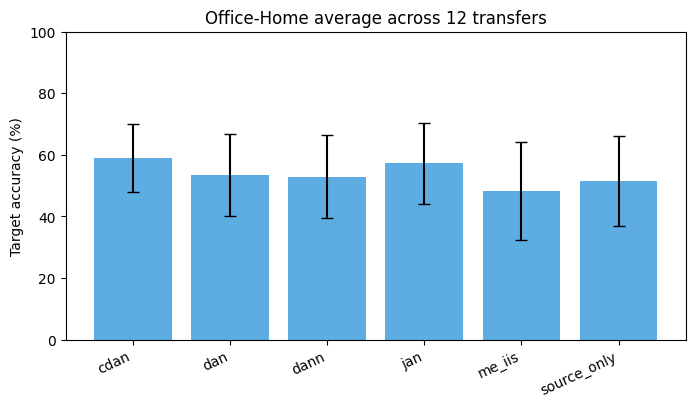

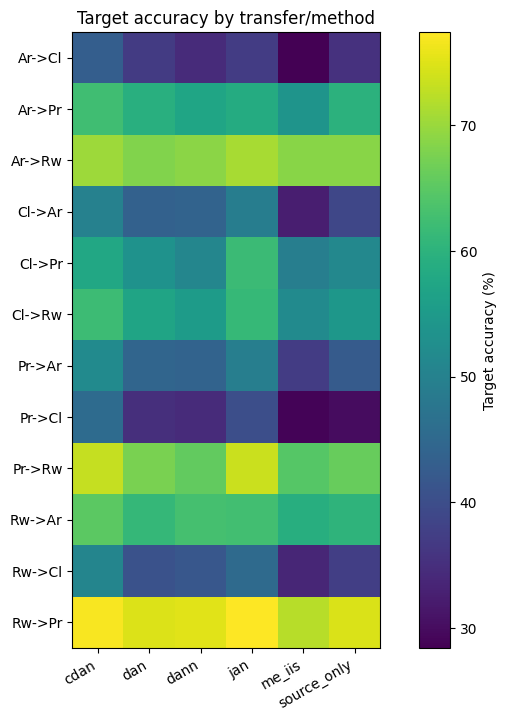

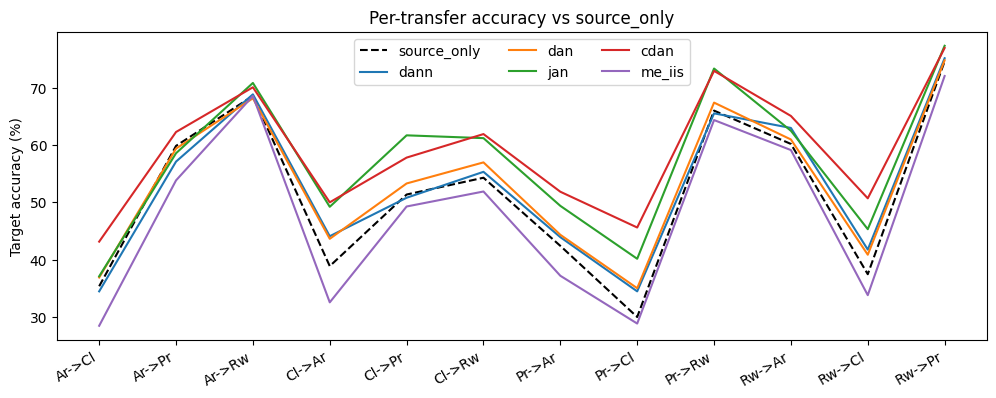

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Bar chart: average target accuracy per method
x_pos = np.arange(len(overall_stats["method"]))
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(
    x_pos,
    overall_stats["target_mean"],
    yerr=overall_stats["target_std"].fillna(0),
    capsize=4,
    color="#5DADE2",
)
ax.set_ylabel("Target accuracy (%)")
ax.set_title("Office-Home average across 12 transfers")
ax.set_ylim(0, 100)
ax.set_xticks(x_pos)
ax.set_xticklabels(overall_stats["method"], rotation=25, ha="right")
plt.show()

# Heatmap: transfer vs methods
pivot = transfer_stats.pivot(index="transfer", columns="method", values="target_mean")
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(pivot.values, cmap="viridis")
ax.set_xticks(np.arange(len(pivot.columns)))
ax.set_xticklabels(pivot.columns, rotation=30, ha="right")
ax.set_yticks(np.arange(len(pivot.index)))
ax.set_yticklabels(pivot.index)
ax.set_title("Target accuracy by transfer/method")
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Target accuracy (%)")
plt.show()

# Optional: per-transfer comparison vs source_only
baseline = pivot["source_only"] if "source_only" in pivot.columns else None
if baseline is not None:
    x_idx = np.arange(len(pivot.index))
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(x_idx, baseline.values, label="source_only", linestyle="--", color="black")
    for method in METHODS:
        if method == "source_only" or method not in pivot.columns:
            continue
        ax.plot(x_idx, pivot[method].values, label=method)
    ax.set_ylabel("Target accuracy (%)")
    ax.set_xticks(x_idx)
    ax.set_xticklabels(pivot.index, rotation=30, ha="right")
    ax.set_title("Per-transfer accuracy vs source_only")
    ax.legend(ncol=3)
    plt.show()


In [14]:
import pandas as pd

status_counts = pd.Series([str(r.get("status", "unknown")) for r in results]).value_counts()
succeeded = sum(1 for r in results if str(r.get("status", "")).lower() in {"done", "trained", "resumed", "skipped"})
failed_runs = [r for r in results if str(r.get("status", "")).startswith("fail")]

print(f"Expected runs: {expected_runs}")
print(f"Succeeded/skipped: {succeeded} | Failed: {len(failed_runs)}")
print("Status counts:")
print(status_counts)

if failed_runs:
    print("Failed runs (see stderr in Drive if available):")
    for fr in failed_runs:
        print(
            f" - {fr.get('method')} {fr.get('src')}->{fr.get('tgt')} seed={fr.get('seed')} "
            f"err={fr.get('stderr', fr.get('error', ''))}"
        )
else:
    print("No failed runs recorded.")

print(f"Summary CSV stored at: {SUMMARY_DRIVE_PATH}")
print(f"Run artifacts stored under: {RUNS_DRIVE / RUN_TAG}")



Expected runs: 72
Succeeded/skipped: 72 | Failed: 0
Status counts:
trained    72
Name: count, dtype: int64
No failed runs recorded.
Summary CSV stored at: /content/drive/MyDrive/ME-IIS/runs/summary_office_home_full_20251216_050010.csv
Run artifacts stored under: /content/drive/MyDrive/ME-IIS/runs/office_home_full_20251216_050010
